# Case study of uniaxial compression tests

This is an example of how to use Paramaterial to process a dataset of uniaxial compression test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [1]:
from matplotlib import pyplot as plt

import paramaterial as pam
import pandas as pd

from paramaterial.plug import DataSet

## Data preparation

Create three directories: "data", "info" and "output".



### Prepare raw data
First, save all csv files into a directory called "data/00 backup data".
Generate a corresponding info table "info/00 backup info.xlsx" using make_info_table function.
The function writes the table to a spreadsheet and returns it as a dataframe.
Fill in the info and save backup info and data. Copy to raw info and data.

In [2]:
backup_info = pam.preparing.make_info_table('data/00 backup data', columns=['temperature', 'rate', 'material'])
backup_info.to_excel('info/00 backup info unfilled.xlsx')
backup_info.head()

,test id,old filename,temperature,rate,material
0,NaN,testID_0080.csv,NaN,NaN,NaN
1,NaN,testID_0081.csv,NaN,NaN,NaN
2,NaN,testID_0082.csv,NaN,NaN,NaN
3,NaN,testID_0083.csv,NaN,NaN,NaN
4,NaN,testID_0084.csv,NaN,NaN,NaN


Add the metadata into the excel spreadsheet.
Apply a naming convention in the "test id" column.

In [3]:
backup_info = pd.read_excel('info/00 backup info.xlsx')
backup_info.head()

,test id,old filename,test type,material,temperature,rate,L_0,D_0
0,baron_test_001,testID_0080.csv,UC,AC,300,100,15,10
1,baron_test_002,testID_0081.csv,UC,AC,300,100,15,10
2,baron_test_003,testID_0082.csv,UC,AC,330,100,15,10
3,baron_test_004,testID_0083.csv,UC,AC,330,100,15,10
4,baron_test_005,testID_0084.csv,UC,AC,360,100,15,10


Copy backup data and info into raw data and info, then leave backup alone in all further steps.

In [4]:
pam.preparing.copy_data_and_info(old_data_dir='data/00 backup data', new_data_dir='data/01 prepared data',
                                 old_info_path='info/00 backup info.xlsx', new_info_path='info/01 prepared info.xlsx')

Copied 167 files from data/00 backup data to data/01 prepared data.
Copied info table from info/00 backup info.xlsx to info/01 prepared info.xlsx.


### Preparing raw data

Rename files according to test id.

In [5]:
# pam.preparing.rename_by_test_id('data/01 prepared data', 'info/01 prepared info.xlsx')

Check that column headers of data files are all the same. If not the same, fix.

In [6]:
pam.preparing.check_column_headers('data/01 prepared data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Strain', 'Stress(MPa)', 'Stroke(mm)', 'TC1(C)', 'wedge(mm)']
Headers in all files are the same as in the first file.


In [7]:
raw_dataset = DataSet('data/01 prepared data', 'info/01 prepared info.xlsx')

## Exploratory Data Analysis

In [8]:
raw_info = raw_dataset.info_table
raw_info.describe()

,temperature,rate,L_0,D_0
count,167.000000,167.000000,167.0,167.0
mean,374.970060,35.191617,15.0,10.0
std,60.209216,36.627880,0.0,0.0
min,300.000000,1.000000,15.0,10.0
25%,330.000000,10.000000,15.0,10.0
50%,360.000000,10.000000,15.0,10.0
75%,400.000000,50.000000,15.0,10.0
max,500.000000,100.000000,15.0,10.0


In [9]:
raw_info.nunique()

test id         167
old filename    167
test type         1
material          3
temperature       6
rate              4
L_0               1
D_0               1
dtype: int64

In [10]:
data_matrix = raw_info[['material', 'temperature', 'rate']].value_counts().sort_index()
data_matrix

material  temperature  rate
AC        300          10      2
                       50      2
                       100     2
          330          10      2
                       50      3
                       100     2
          360          10      2
                       50      3
                       100     3
          400          1       2
                       10      2
                       50      2
                       100     2
          450          1       2
                       10      2
          500          1       2
                       10      2
H560      300          10      6
                       50      2
                       100     2
          330          10      4
                       50      2
                       100     2
          360          1       2
                       10      4
                       50      2
                       100     2
          400          1       2
                       10      2
               

Make the experimental matrix.

In [11]:
data_matrix = data_matrix.to_frame().reset_index()
data_matrix.columns = ['material', 'temperature', 'rate', 'count']
data_matrix.pivot_table(index=['material', 'rate'], columns='temperature', values='count').fillna(0).astype(int)

temperature    300  330  360  400  450  500
material rate                              
AC       1       0    0    0    2    2    2
         10      2    2    2    2    2    2
         50      2    3    3    2    0    0
         100     2    2    3    2    0    0
H560     1       0    0    2    2    3    2
         10      6    4    4    2    2    2
         50      2    2    2    5    0    0
         100     2    2    2    1    0    0
H580     1       0    0    1    5    4    2
         10      9    7    4    7    7    4
         50      4    5    3    4    0    0
         100     2    5    5    5    0    0

Plot the dataset.

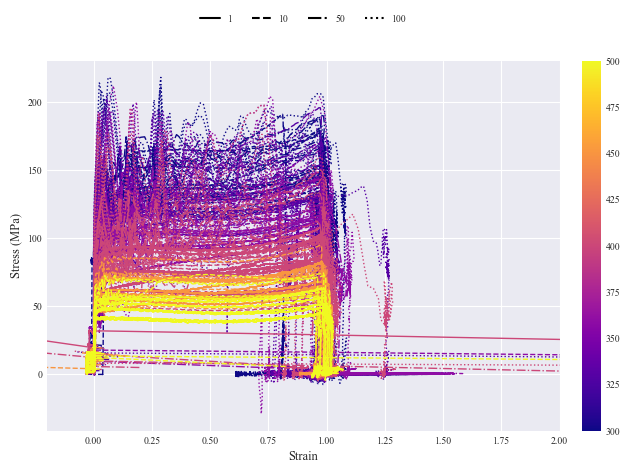

In [12]:
pam.plotting.dataset_plot(raw_dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)', cbar_by='temperature', style_by='rate', alpha=1,
                          xlim=(-0.2, 1.5), grid=True)
plt.show()

(<Figure size 1200x800 with 13 Axes>,
 array([[<AxesSubplot: title={'center': '1 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: title={'center': '10 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: title={'center': '50 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: title={'center': '100 s$^{-1}$'}, xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>],
        [<AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>,
         <AxesSubplot: xlabel='Strain', ylabel='Stress (MPa)'>]],
       dtype=object))

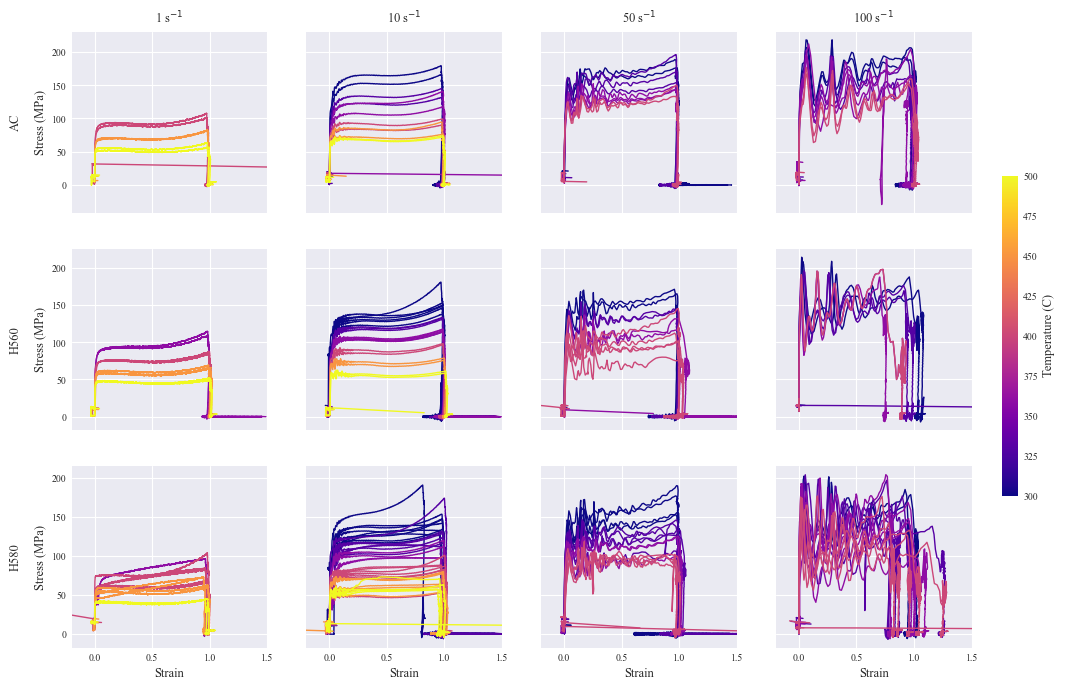

In [14]:
pam.plotting.dataset_subplots(raw_dataset, x='Strain', y='Stress(MPa)', ylabel='Stress (MPa)',
                              nrows=3, ncols=4,
                              rows_by='material', cols_by='rate',
                              row_keys=[['AC'],['H560'],['H580']], col_keys=[[1],[10],[50],[100]],
                              row_titles=['AC', 'H560', 'H580'], col_titles=['1 s$^{-1}$', '10 s$^{-1}$', '50 s$^{-1}$', '100 s$^{-1}$'],
                              cbar_by='temperature', cbar_label='Temperature (C)',
                              xlim=(-0.2, 1.5), grid=True)